# bioNER project

Project repository with description and files: https://github.com/steysie/bioNER 

In [0]:
import json
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import itertools

from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch
from torch.utils.data import Dataset, DataLoader

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

## Loading and Preprocessing Dataset


In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "steysie" # username from the json file 
os.environ['KAGGLE_KEY'] = "6469ce63000a8caf2a50989e9bb90b19" # key from the json file

In [8]:
!kaggle datasets download -d rsnayak/hackathon-disease-extraction-saving-lives-with-ai # api copied from kaggle

hackathon-disease-extraction-saving-lives-with-ai.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!unzip hackathon-disease-extraction-saving-lives-with-ai.zip

Archive:  hackathon-disease-extraction-saving-lives-with-ai.zip
replace Problem Statement - Disease Extraction.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace sample_submission_usrypCc/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace sample_submission_usrypcc/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test_XEV14AD/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test_xev14ad/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train_3PIRKSI/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train_3pirksi/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [0]:
train = pd.read_csv("train_3pirksi/train.csv")
test = pd.read_csv("test_xev14ad/test.csv")

In [11]:
train = train.dropna(subset=['Word'])
train.Word = train.Word.str.lower()

train.head(3)

,id,Doc_ID,Sent_ID,Word,tag
0,1,1,1,obesity,O
1,2,1,1,in,O
2,3,1,1,low-,O


## Mapping Categories to Indexes

In [12]:
cat_mapper = {tag: n for n, tag in enumerate(train.tag.unique())}
cat_mapper

{'B-indications': 1, 'I-indications': 2, 'O': 0}

In [0]:
train.tag = train.tag.map(cat_mapper)

In [0]:
# group sentences by id
grouped = train.groupby('Sent_ID').agg(lambda x: x.tolist())

In [0]:
sents = grouped.Word.tolist()
tags = grouped.tag.tolist()

### Chunking long sequences

Too many long sequences. We are going to chunk them into smaller sequences.

In [0]:
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    if len(out[-1]) == 1:
        out[-2].extend(out[-1])
        out.remove(out[-1])

    return out

In [0]:
class betterGroupedSents:

    def __init__(self):
        self.lengths = 0        
        self.deletions = 0      # will record the deletions of emptified sentences
        self.i_movement = 0     # will record how many words with I tag moved to previous sentence

    def chunkGroupedSents(self, old_sents, tags_raw, maxlen=32):
        l = len(old_sents)
        sents = []

        for i in range(l):
            # if sentence is longer than the specified maxlen, let's chunk it into sequences of roughly specified max length (+1 in case of residuals)
            if len(old_sents[i]) > maxlen:
                sents.extend(chunkIt(old_sents[i], len(old_sents[i])/maxlen))

            else: 
                sents.append(old_sents[i])

        lengths = 0
        deletions = 0 # will record the deletions of emptified sentences
        i_movement = 0 # will record how many words with I tag moved to previous sentence

        for i in range(len(sents)):
            try:
                # len(sents) will change over time so we need to check that we didn't exceed the limit
                if i == len(sents)-2:
                    lengths += len(sents[i])
                    #lengths += len(sents[i+1])
                    #print(lengths)
                    break

                if tags_raw[lengths+len(sents[i])] == 2:    # if tags_raw[lengths+len(sents[i])-1] in [1, 2] and
                    cursor = lengths+len(sents[i])  # index of the first element of the next sequence if the count starts from the current sequence
                    next_len = len(sents[i+1])   # length of the next sequence
                    
                    pairs = zip(sents[i+1], tags_raw[cursor:cursor+next_len])   # to be able to retrieve both the sentence and its tag seq by the same index
                    
                    # get all the starting 2's - so that later we can move them to the previous sequence  But! we should make sure only starting 2's are retrieved not all
                    match = []
                    for w, t in pairs:
                        if t==2:
                            match.append(w)
                        else:
                            break

                    sents[i].extend(match)
                    del sents[i+1][0:len(match)]
                    i_movement += len(match)

                # if the next sequence len == 0 or
                if (sents[i+1]) and (len((sents[i+1])) == 0 or (len(sents[i+1]) <= 3 and (any(x in sents[i+1] for x in ['.','!','?', ';', ')'])))):
                    sents[i].extend(sents[i+1])
                    del sents[i+1]
                    deletions += 1


                lengths += len(sents[i])
            
            except IndexError as e:
                print(e)
                print(lengths)
                print(deletions)
                break
        
        self.lengths = lengths       
        self.deletions = deletions
        self.i_movement = i_movement

        return sents

In [0]:
grFunc = betterGroupedSents()

In [0]:
raw_sents = sents

In [0]:
grouped_sents = grFunc.chunkGroupedSents(raw_sents, train.tag.tolist(), 32)

### Grouping Tags with respect to Corresponding Sentence Lengths

Now we have a list of sentences. Let's create a list of tags with corresponding lengths.

In [21]:
# Same on real tags

tags_raw = train.tag.tolist()
tags = []
c = 0


for i in range(len(grouped_sents)):
    try:
        tags.append(tags_raw[c:c+len(grouped_sents[i])])
        c += len(grouped_sents[i])
    except IndexError:
        print(i)

print(len(tags), len(grouped_sents))

220737 220737


In [22]:
maxlen = 25
minlen = 3
num = 0

for n, i in enumerate(tags):
    if len(i) > maxlen:
        maxlen = len(i)
        num = n
    elif len(i) < minlen:
        minlen = len(i)

print(f"The maximum sequence length is {maxlen}, and the minimum sequence length is {minlen}")
print(f"The longest sequence is #{num}")

The maximum sequence length is 39, and the minimum sequence length is 1
The longest sequence is #34363


Let's see the sequence length distribution over the corpus

In [23]:
lengths = []

for text in tqdm(grouped_sents):
    lengths.append(len(text))

100%|██████████| 220737/220737 [00:00<00:00, 2063314.45it/s]


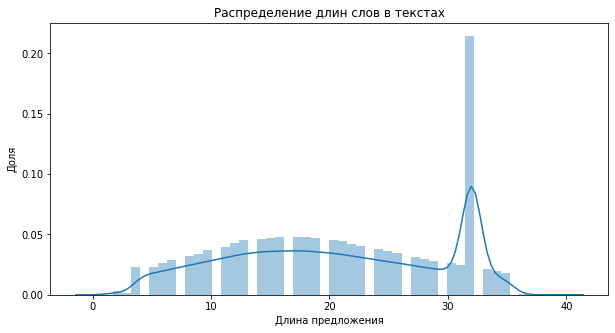

In [24]:
plt.figure(figsize=(10, 5))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sn.distplot(lengths)

## Building a knowledge graph

This approach is an unsupervised approach to indentify named entities and create a knowledge graph

In [0]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [0]:
corpus_list = [' '.join(k) for k in grouped_sents]

In [27]:
# candidate_sentences are sentences
candidate_sentences = corpus_list[:8000]
len(candidate_sentences)

8000

In [28]:
candidate_sentences[88]

'in contrast to other reports , maximum fluorescence response occurred after a derivatisation time of 8 min .'

The rule defined for entity extraction - **extract the subject/object along with its modifiers, compound words and also extract the punctuation marks between them.**

In [29]:
doc = nlp(candidate_sentences[88])

for tok in doc:
  print(tok.text, "...", tok.dep_)

in ... prep
contrast ... pobj
to ... prep
other ... amod
reports ... pobj
, ... punct
maximum ... amod
fluorescence ... compound
response ... nsubj
occurred ... ROOT
after ... prep
a ... det
derivatisation ... compound
time ... pobj
of ... prep
8 ... nummod
min ... pobj
. ... punct


Next, we will extract entities from sentences based on dependency parsing results.

In [0]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [31]:
get_entities(candidate_sentences[88])

['maximum fluorescence response', '8 derivatisation min']

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [33]:
entity_pairs = []

for i in tqdm(candidate_sentences):
  entity_pairs.append(get_entities(i))

100%|██████████| 8000/8000 [01:28<00:00, 90.18it/s]


In [0]:
import pickle

In [0]:
with open("/content/drive/My Drive/bioNER datasets/entity_pairs.txt", "wb") as fp:   #Pickling
    pickle.dump(entity_pairs, fp)

In [38]:
entity_pairs[1502:1510]

[['weighted  imaging', 'microstructural imaging tissue'],
 ['apparent diffusion coefficient', 'random water molecules'],
 ['electromyography', 'diagnostic  myositis'],
 ['aim', 'myositis emg patients'],
 ['seven  patients', '19  study'],
 ['diagnosis', 'case'],
 ['dwi', 'b  values'],
 ['needle electromyography', '3  mri']]

### Retrieving relations between entity pairs

Our hypothesis is that the predicate is actually the main verb in a sentence. Here, spaCy’s rule-based matching is used

In [0]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [41]:
get_relation("in contrast to other reports , maximum fluorescence response occurred after a derivatisation time of 8 min .")

'occurred after'

In [42]:
relations = [get_relation(i) for i in tqdm(candidate_sentences)]

100%|██████████| 8000/8000 [01:26<00:00, 91.99it/s]


In [0]:
with open("/content/drive/My Drive/bioNER datasets/relations.txt", "wb") as fp:   #Pickling
    pickle.dump(relations, fp)

In [0]:
len(pd.Series(relations).value_counts())

53591

In [43]:
pd.Series(relations).value_counts()[:20]

was             254
is              253
were            120
showed           88
found            80
used             69
are              68
suggest          51
had              48
show             43
revealed         39
in               37
demonstrated     34
performed        34
indicate         32
shown            32
observed         32
indicated        31
studied          31
increased        31
dtype: int64

It turns out that relations like “A is B” and “A was B” are the most common relations. However, there are quite a few relations that are more associated with the overall medical and biological-science theme. Some of the examples are “indicate”, “investigated”, “revealed” and a few more.

In [46]:
pd.Series(relations).value_counts()[50:60]

correlated with    16
demonstrate        16
assessed           15
include            15
received           14
measured           13
conducted          13
decreased          13
used for           12
concluded          12
dtype: int64

### Building a knowledge graph

We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

In [0]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

Next, we will use the networkx library to create a network from this dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.

It is going to be a directed graph. In other words, the relation between any connected node pair is not two-way, it is only from one node to another. 

In [0]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 36733 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 25991 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 34987 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 24341 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 29992 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_

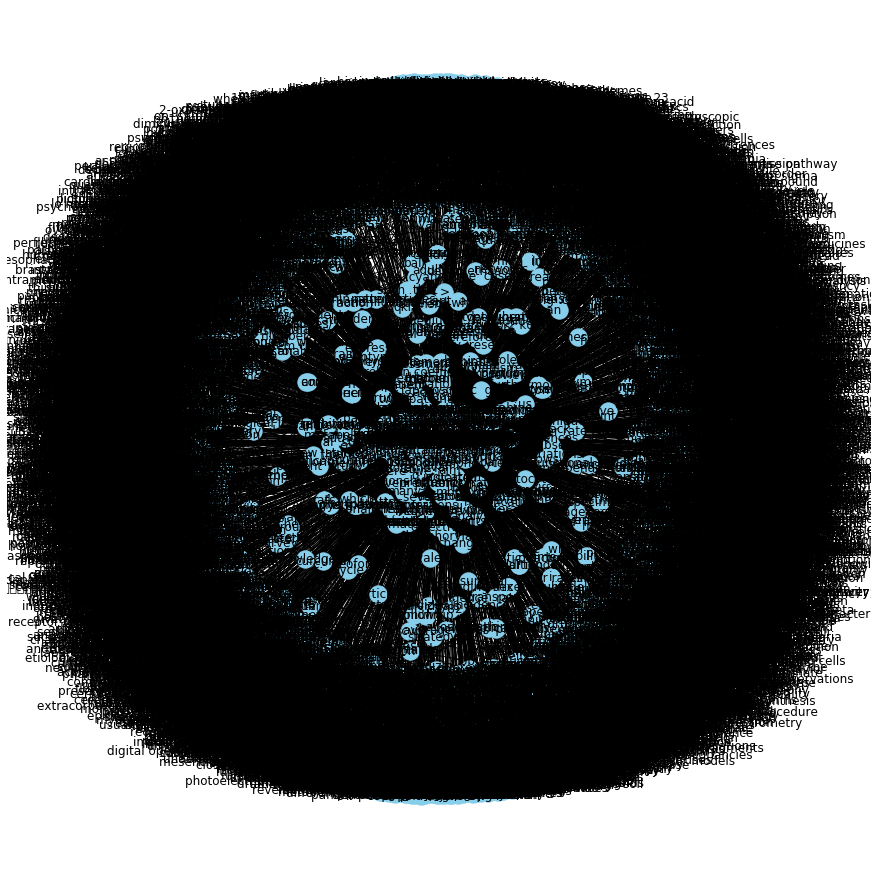

In [49]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, font_family='sans-serif', pos = pos)
plt.show()

It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates.

So, it’s advisable to use only a few important relations to visualize a graph. Let's take one relation at a time. Let’s start with the relation “revealed”

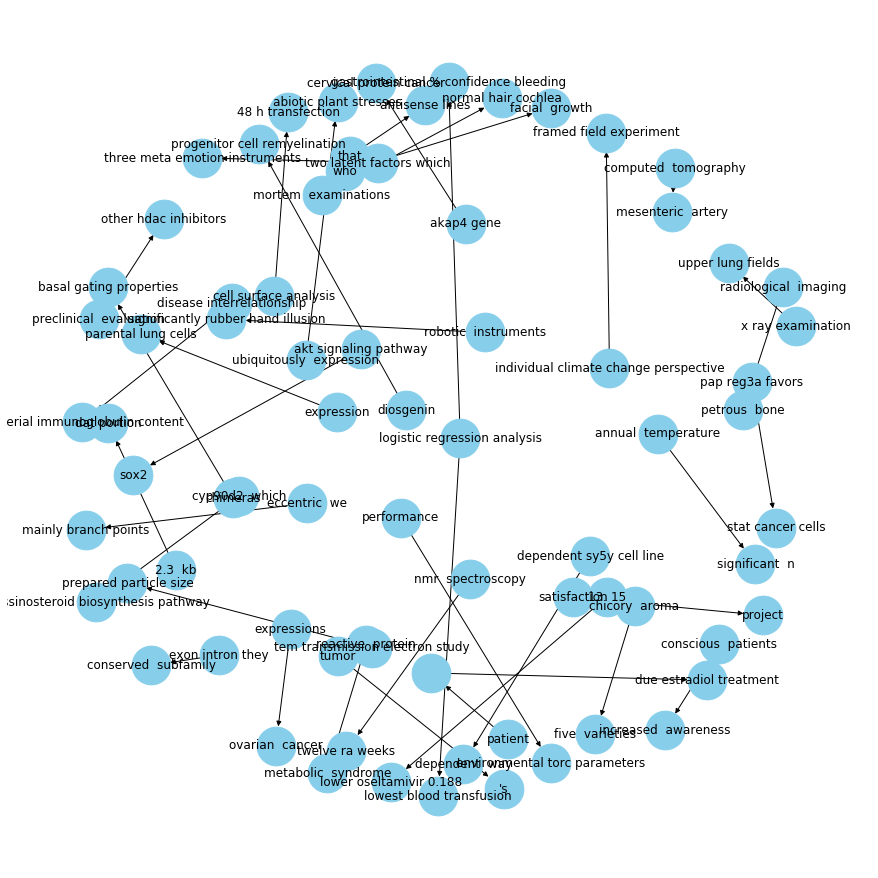

In [51]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="revealed"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Let’s check out a few more relations.

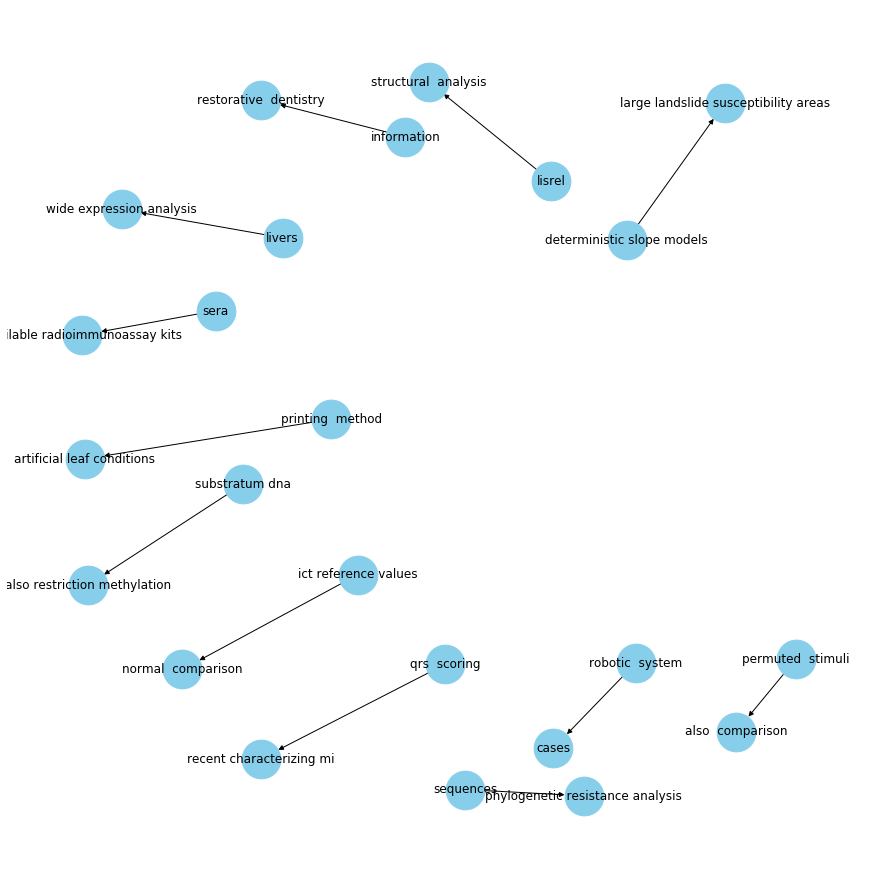

In [75]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="used for"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

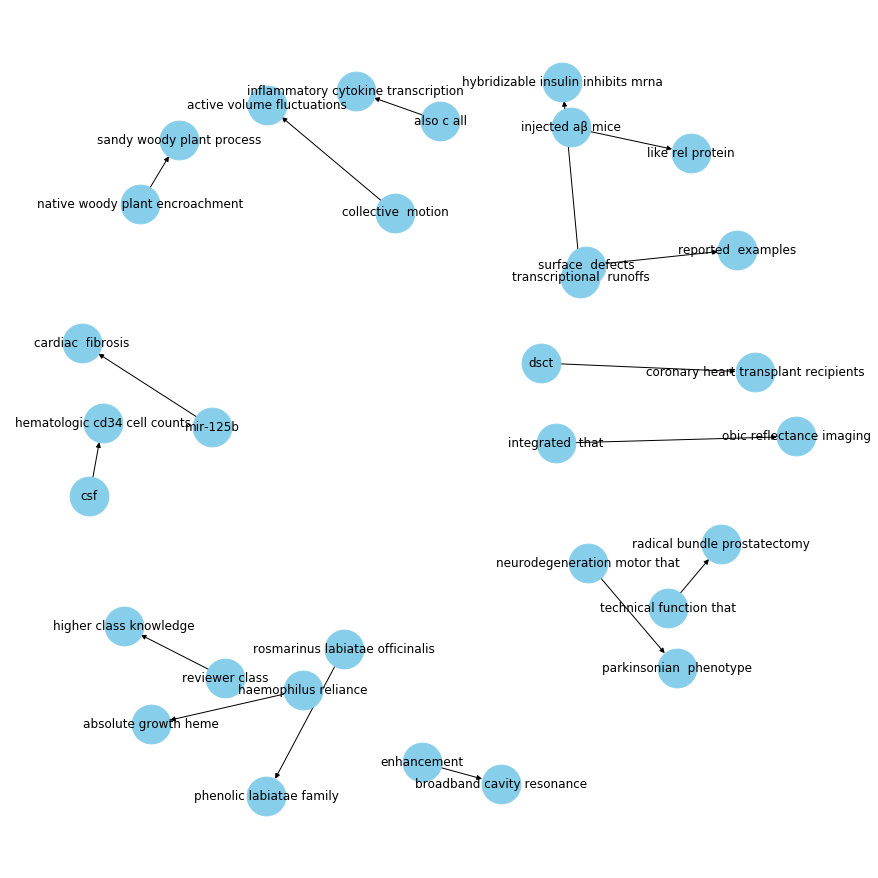

In [100]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="demonstrate"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

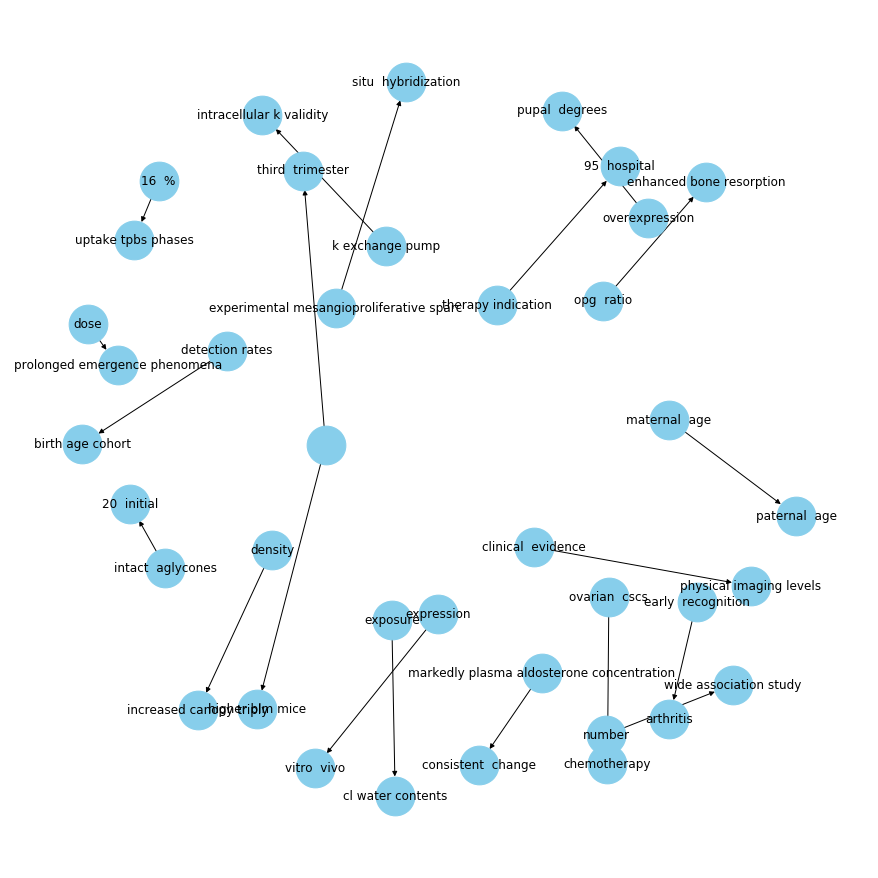

In [0]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="correlated with"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

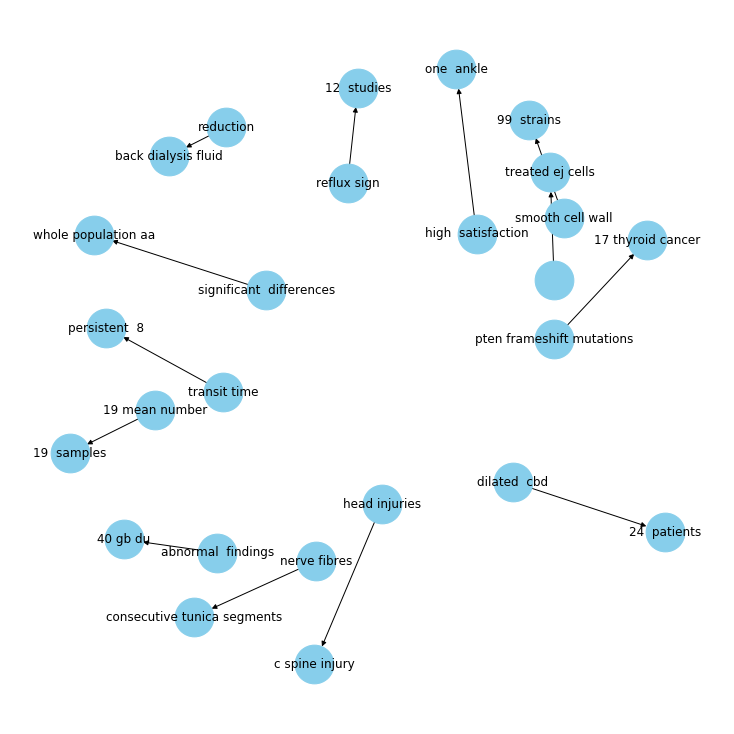

In [0]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="found in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## Converting to CONLL(u) format

To train GCN, we need syntactic graphs and other info. We will store it in conllu format.

In [0]:
!wget https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-2998/english-ewt-ud-2.4-190531.udpipe

--2019-12-23 12:23:50--  https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-2998/english-ewt-ud-2.4-190531.udpipe
Resolving lindat.mff.cuni.cz (lindat.mff.cuni.cz)... 195.113.20.140
Connecting to lindat.mff.cuni.cz (lindat.mff.cuni.cz)|195.113.20.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16477964 (16M) [application/octet-stream]
Saving to: ‘english-ewt-ud-2.4-190531.udpipe’

english-ewt-ud-2.4- 100%[===================>]  15.71M  77.5MB/s    in 0.2s    

2019-12-23 12:23:51 (77.5 MB/s) - ‘english-ewt-ud-2.4-190531.udpipe’ saved [16477964/16477964]



In [0]:
!pip install corpy

     |████████████████████████████████| 194kB 23.3MB/s 
     |████████████████████████████████| 307kB 47.8MB/s 
     |████████████████████████████████| 5.8MB 61.5MB/s 
  Created wheel for ufal.morphodita: filename=ufal.morphodita-1.9.2.3-cp36-cp36m-linux_x86_64.whl size=2386652 sha256=08f61090fb1ece212cf59b0740ee0e77781f11a5a263b9cb3cee98a94674217a
  Stored in directory: /root/.cache/pip/wheels/26/07/97/30a28faef0a90a508fed63793066e9c1fc25554121a965c9fd
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp36-cp36m-linux_x86_64.whl size=5625867 sha256=d534937cca45edfbfa7cf4536d6b4bcd8ece006f0d6051be8eee058b76c3a4cc
  Stored in directory: /root/.cache/pip/wheels/0c/9d/db/6d3404c33da5b7adb6c6972853efb6a27649d3ba15f7e9bebb
Successfully built ufal.morphodita ufal.udpipe
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [0]:
from corpy.udpipe import Model
m = Model("english-ewt-ud-2.4-190531.udpipe")

INFO:corpy.udpipe:Loading model.


In [0]:
sents = list(m.process(i) for i in ["I go to school.", "Weather is nice"])
sents

In [0]:
grouped_sents[0]

['obesity',
 'in',
 'low-',
 'and',
 'middle-income',
 'countries',
 ':',
 'burden',
 ',',
 'drivers',
 ',',
 'and',
 'emerging',
 'challenges',
 '.']

In [0]:
a = ['my', 'big', 'table', '.']
b = '\n'.join(a)
b

'my\nbig\ntable\n.'

In [0]:
conllu_sents = list(m.process(b, in_format="horizontal", out_format="conllu"))

In [0]:
print("".join(conllu_sents), end="")

# newdoc
# newpar
# sent_id = 1
1	my	my	PRON	PRP$	Number=Sing|Person=1|Poss=Yes|PronType=Prs	0	root	_	_

# sent_id = 2
1	big	big	ADJ	JJ	Degree=Pos	0	root	_	_

# sent_id = 3
1	table	table	NOUN	NN	Number=Sing	0	root	_	_

# sent_id = 4
1	.	.	PUNCT	.	_	0	root	_	_



In [0]:
corpus_list = [' '.join(k) for k in grouped_sents]

In [0]:
corpus = '\n'.join(corpus_list)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pickle

In [0]:
conllu_sents = list(m.process(corpus, in_format="horizontal", out_format="conllu"))

In [0]:
with open("/content/drive/My Drive/bioNER datasets/sents_conllu.txt", "wb") as fp:   #Pickling
    pickle.dump(conllu_sents, fp)

### Import the conllu

In [0]:
with open("/content/drive/My Drive/bioNER datasets/sents_conllu.txt", "rb") as fp:   # Unpickling
    conllu_sents = pickle.load(fp)

In [0]:
print("".join(conllu_sents[5:7]), end="")

### Playground

In [0]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [0]:
!python -m spacy validate

✔ Loaded compatibility table

====================== Installed models (spaCy v2.1.9) ======================
ℹ spaCy installation: /usr/local/lib/python3.6/dist-packages/spacy

TYPE      NAME             MODEL            VERSION                            
package   en-core-web-sm   en_core_web_sm   2.1.0   ✔
link      en               en_core_web_sm   2.1.0   ✔



In [0]:
import spacy
# Load the installed model "en_core_web_sm"
nlp = spacy.load("en_core_web_sm")

In [0]:
from spacy import displacy

In [0]:
doc = nlp("This is a sentence")
displacy.serve(doc, style="dep")   # render for jupyter notebook


Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [0]:
!pip install spacy_conll

In [0]:
from spacy_conll import Spacy2ConllParser
spacyconll = Spacy2ConllParser()

# `parse` returns a generator of the parsed sentences
for parsed_sent in spacyconll.parse(input_str='I like cookies. What about you? I don\'t like \'em!'):
    #print(parsed_sent)
    pass

# `parseprint` prints output to stdout (default) or a file (use `output_file` parameter)
# This method is called when using the command line
spacyconll.parseprint(input_str='I like cookies.')

1	I	-PRON-	PRON	PRP	PronType=prs	2	nsubj	_	_
2	like	like	VERB	VBP	VerbForm=fin|Tense=pres	0	ROOT	_	_
3	cookies.	cookies.	NOUN	NNS	Number=plur	2	dobj	_	_



## Footnotes to graph generation

We extracted information from the medical corpus in the form of triples and built a knowledge graph from it.

Even though we restricted ourselves to use sentences with exactly 2 entities, we were able to build quite informative knowledge graphs. 